# Web Scraping and Data Mining

### By Mark Kamuda


In [1]:
%matplotlib inline

from IPython.display import Image
import urllib2
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import requests
import re

![title](images/DataMiningOverview2.png)


* ## Two methods to do web scraping
  * #### Parse a websites HTML manually
      * #### BeautifulSoup is a popular choice in python
  * #### Use an API provided by the website
<br><br><br>

* ## In this tutorial we'll be using BeautifulSoup
  * #### We don't need no stinkin' API https://blog.hartleybrody.com/web-scraping/
<br><br><br><br>
*  ## There are a few web scrapping rules.
##### 1. Make sure it's okay to scrape a site and use the data
##### 2. Constantly sending requests to a website can kill it and makes you look malicious.
##### 3. Sites can change layouts often. This may break your scrapper. Be aware.

In [2]:
# Choose your URL

def GetDataFromSubreddit(url):
    
    # Headers make you look like a real web browser
    example_headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:50.0) Gecko/20100101 Firefox/50.0'}
    
    # Sleep makes sure a website doesn't feel attacked 
    time.sleep(2)
    
    # requests.get acts like a web browser and asks websites for their html
    r  = requests.get(url,headers=example_headers)
    
    # Make the result of the request text for BeautifulSoup 
    data = r.text
    
    # Make some soup. Use the 'lxml' parser
    soup = BeautifulSoup(data, "lxml")
    
    return soup

In [3]:
soup = GetDataFromSubreddit('http://www.reddit.com/r/aww/.rss')

## Check out that ugly soup

In [4]:
print soup

<?xml version="1.0" encoding="UTF-8"?><html><body><feed xmlns="http://www.w3.org/2005/Atom"><category label="r/aww" term="aww"></category><updated>2018-02-21T19:44:59+00:00</updated><icon>https://www.redditstatic.com/icon.png/</icon><id>/r/aww/.rss</id><link href="https://www.reddit.com/r/aww/.rss" rel="self" type="application/atom+xml"/><link href="https://www.reddit.com/r/aww/" rel="alternate" type="text/html"/><logo>https://b.thumbs.redditmedia.com/8U9QAgkPwVnEABNOOnaMzOC3hhRpA2bblHxEJHdTGFA.png</logo><subtitle>Things that make you go AWW! Like puppies, bunnies, babies, and so on... A place for really cute pictures and videos!</subtitle><title>A subreddit for cute and cuddly pictures</title><entry><author><name>/u/N8theGr8</name><uri>https://www.reddit.com/user/N8theGr8</uri></author><category label="r/aww" term="aww"></category><content type="html">&lt;!-- SC_OFF --&gt;&lt;div class="md"&gt;&lt;p&gt;nominations thread:&lt;/p&gt; &lt;p&gt;&lt;a href="https://www.reddit.com/r/aww/com

# Make the soup more human readible

In [5]:
print soup.prettify()


<?xml version="1.0" encoding="UTF-8"?>
<html>
 <body>
  <feed xmlns="http://www.w3.org/2005/Atom">
   <category label="r/aww" term="aww">
   </category>
   <updated>
    2018-02-21T19:44:59+00:00
   </updated>
   <icon>
    https://www.redditstatic.com/icon.png/
   </icon>
   <id>
    /r/aww/.rss
   </id>
   <link href="https://www.reddit.com/r/aww/.rss" rel="self" type="application/atom+xml"/>
   <link href="https://www.reddit.com/r/aww/" rel="alternate" type="text/html"/>
   <logo>
    https://b.thumbs.redditmedia.com/8U9QAgkPwVnEABNOOnaMzOC3hhRpA2bblHxEJHdTGFA.png
   </logo>
   <subtitle>
    Things that make you go AWW! Like puppies, bunnies, babies, and so on... A place for really cute pictures and videos!
   </subtitle>
   <title>
    A subreddit for cute and cuddly pictures
   </title>
   <entry>
    <author>
     <name>
      /u/N8theGr8
     </name>
     <uri>
      https://www.reddit.com/user/N8theGr8
     </uri>
    </author>
    <category label="r/aww" term="aww">
    </cat

### Filter HTML tags using find_all('TagName') to find what we want.

In [6]:
post_titles = soup.find_all('title')

print post_titles[3]

<title>Tank Puppy sees snow for the firs time at the Toronto Zoo.</title>


In [7]:
post_UserNames = soup.find_all('name')

print post_UserNames[10]

<name>/u/chukomoo</name>


### Using the HTML tags,  lets make a function that gets us the titles and upvotes from soup

In [8]:
def GetTitlesFromSoup(_soup):
    
    # Make an empty list for the post titles
    titles_all = []
    # Find all of the 'title' HTML tags
    post_titles = _soup.find_all('title')
    
    # Play with strings
    post_titles_as_strings = str(post_titles)
    post_titles_as_strings = post_titles_as_strings.split('</title>,')
    
    
    for i in range(1,len(post_titles_as_strings)):
        # append the post title to titles all
        # the first 8 entries of post_titles_as_strings is '</title>'
        titles_all.append(post_titles_as_strings[i][8:].split())
    
    # This removes '</title>' from the last entry of the last row. Because I used .split('</title>,')
    titles_all[-1][-1] = titles_all[-1][-1][:-9]
    
    # Return all but the first two posts (which are sticky posts). Return as numpy array.
    return np.asarray(titles_all[2:])


def GetUpvotesFromSoup(_soup):
    
    # Make empty list for the upvotes
    all_upvotes = []
    
    # Make soup a text string
    soup_as_strings=str(_soup)
    
    # For each thing in the soup separated by a space ... 
    for string in soup_as_strings.split(' '):
        # print string =>
        # data-score="38865"
        if 'data-score' in string:
            # make the 12th to last element an integer
            all_upvotes.append(int(string[12:-1]))
    
    # Return all but the first two posts (which are sticky posts). Return as numpy array.
    return np.asarray(all_upvotes[2:])



### We can also get the last posts ID so we can *#133T #hack* the URL to get the next page

In [9]:
def GetLastPostID(_soup):
    
    # Get the posts ID
    post_id = _soup.find_all('id')

    # Save the last post ID
    post_ID_last = str(post_id[-1])[4:-5]
    return post_ID_last


In [10]:
print GetLastPostID(soup)

t3_7yxygl


### Lets make a function that gets us the titles and upvotes from the top posts from the week

In [13]:
def GetTitlesAndUpvotesTOP(numberOfPages):
    
    _allTitles = []
    _allUpvotes = []
    
    
    example_headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:50.0) Gecko/20100101 Firefox/50.0'}

    r_html  = requests.get('https://www.reddit.com/r/aww/top/?sort=top&t=week',headers=example_headers)
    r_lxml  = requests.get('https://www.reddit.com/r/aww/top/.rss?sort=top&t=week/',headers=example_headers)

    data_html = r_html.text
    data_lxml = r_lxml.text

    soup_html = BeautifulSoup(data_html, 'html.parser')
    soup_lxml = BeautifulSoup(data_lxml, 'lxml')
    
    
    all_titles = GetTitlesFromSoup(soup_lxml)
    all_upvotes = GetUpvotesFromSoup(soup_html)
    
    _allTitles.extend(all_titles)
    _allUpvotes.extend(all_upvotes)
    

    
    for k in range(1,numberOfPages):
        LastPostID = GetLastPostID(soup_lxml)
        
        r_html  = requests.get('https://www.reddit.com/r/aww/top/?sort=top&t=week&count='+str(25*k)+'&after='+LastPostID,headers=example_headers)
        r_lxml  = requests.get('https://www.reddit.com/r/aww/top/.rss?sort=top&t=week&count='+str(25*k)+'&after='+LastPostID,headers=example_headers)

        data_html = r_html.text
        data_lxml = r_lxml.text

        soup_html = BeautifulSoup(data_html, 'html.parser')
        soup_lxml = BeautifulSoup(data_lxml, 'lxml')


        all_titles = GetTitlesFromSoup(soup_lxml)
        all_upvotes = GetUpvotesFromSoup(soup_html)

        _allTitles.extend(all_titles)
        _allUpvotes.extend(all_upvotes)
    
    if len(_allUpvotes) == len(_allTitles):
        print 'Green! You have ' + str(len(_allTitles)) + ' data points'
    if len(_allUpvotes) != len(_allTitles):
        print 'RED!'
    
    
    return _allUpvotes,_allTitles
    
    

In [14]:
allUpvotes,allTitles = GetTitlesAndUpvotesTOP(10)

Green! You have 230 data points


# _Mine That Data!_

## Visualize the Data

In [15]:
# create an array of title lengths
title_lengths = [len(string) for string in allTitles]

# rename allUpvotes 
total_upvotes = allUpvotes

# stack total_upvotes and title_lengths (pairwise join)
UpvotesAndTitleLengths = np.stack((total_upvotes,title_lengths),axis=-1)

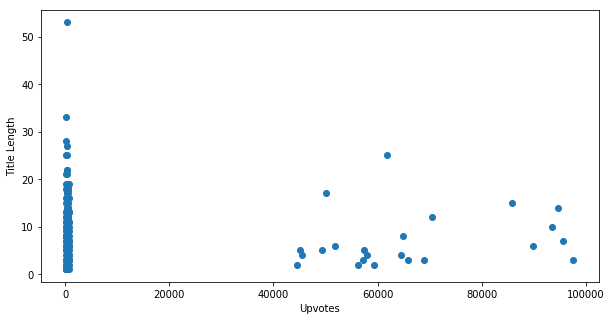

In [16]:
plt.figure(figsize=(10,5))
plt.scatter(total_upvotes,title_lengths)
plt.rcParams.update({'font.size': 20})
plt.xlabel('Upvotes')
plt.ylabel('Title Length')

## Lets check if the number of upvotes is correlated to the length of the title

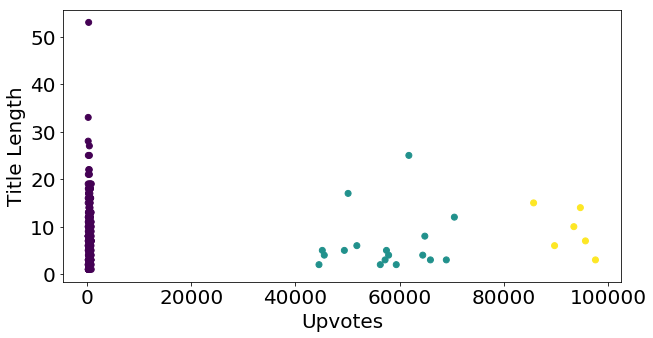

In [17]:
# do a k-means cluster to check for paterns
kmeans = KMeans(n_clusters=3, random_state=0).fit(UpvotesAndTitleLengths)

plt.figure(figsize=(10,5))
plt.scatter(total_upvotes,title_lengths,c=kmeans.predict(UpvotesAndTitleLengths))
plt.xlabel('Upvotes')
plt.ylabel('Title Length')

## Are the length of words important to get more upvotes?

In [18]:
# Make an empty list for the number of characters in each title
number_of_chars_in_title = []

for i in range(len(allTitles)):
    # Play with strings
    number_of_chars_in_title.append(np.sum([len(string) for string in allTitles[i]]))

# Compute avearage word length in each title
average_word_length= np.array(number_of_chars_in_title)/np.array(title_lengths, dtype='float32')

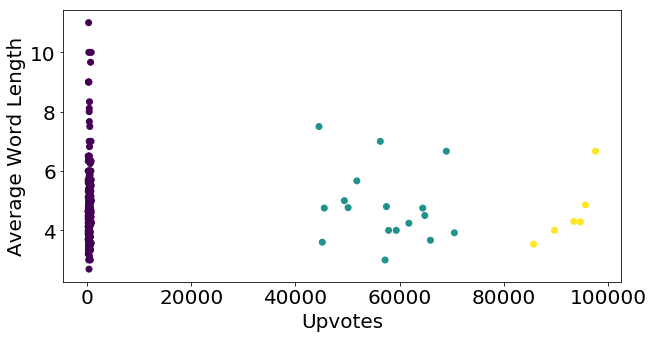

In [19]:
# Stack the total upvotes and average word length
UpvotesAndAverageWordLengths = np.stack((total_upvotes,average_word_length),axis=-1)

# Perform k-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(UpvotesAndAverageWordLengths)

plt.figure(figsize=(10,5))
plt.scatter(total_upvotes,average_word_length,c=kmeans.predict(UpvotesAndAverageWordLengths))
plt.xlabel('Upvotes')
plt.ylabel('Average Word Length')
#plt.xlim([0,10000])

## lets check these out together 

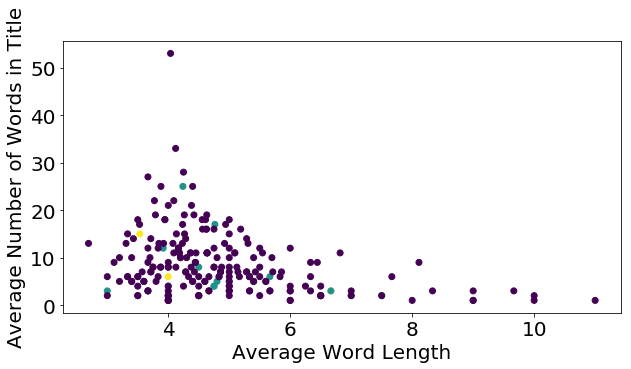

In [20]:
plt.figure(figsize=(10,5))
plt.scatter(average_word_length,title_lengths,c=kmeans.predict(UpvotesAndTitleLengths))
plt.xlabel('Average Word Length')
plt.ylabel('Average Number of Words in Title')

## What if we wanted to scrape images?

In [21]:
# create an empty list for image urls
image_URLs = []

# get all tags with 'content'
content = soup.find_all('content')

for i in range(len(content)):
    
    URL_string = str(content[i]).split(';')[29][8:-4]

    if 'jpg' in URL_string:
        f = open('%02d.jpg' %i,'wb')
        f.write(urllib2.urlopen(URL_string).read())
        f.close()